In [158]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, cohen_kappa_score
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import RandomOverSampler

In [159]:
df = pd.read_csv('./data/sample.csv')

In [160]:
df

,action_taken_name,agency_name,applicant_ethnicity_name,applicant_race_name_1,applicant_sex_name,applicant_income_000s,co_applicant_ethnicity_name,co_applicant_race_name_1,co_applicant_sex_name,county_name,...,owner_occupancy_name,preapproval_name,property_type_name,purchaser_type_name,hud_median_family_income,loan_amount_000s,number_of_1_to_4_family_units,number_of_owner_occupied_units,minority_population,population
0,Application denied by financial institution,Consumer Financial Protection Bureau,Not Hispanic or Latino,White,Female,176.0,No co-applicant,No co-applicant,No co-applicant,Chautauqua County,...,Not owner-occupied as a principal dwelling,Not applicable,One-to-four family dwelling (other than manufa...,Loan was not originated or was not sold in cal...,60000.0,235,2605.0,930.0,6.850000,2979.0
1,Application withdrawn by applicant,Department of Housing and Urban Development,Not Hispanic or Latino,White,Male,53.0,No co-applicant,No co-applicant,No co-applicant,Erie County,...,Owner-occupied as a principal dwelling,Not applicable,One-to-four family dwelling (other than manufa...,Loan was not originated or was not sold in cal...,69000.0,108,2053.0,821.0,33.580002,4416.0
2,Loan originated,Consumer Financial Protection Bureau,Not Hispanic or Latino,White,Male,223.0,Not Hispanic or Latino,White,Female,Queens County,...,Owner-occupied as a principal dwelling,Not applicable,One-to-four family dwelling (other than manufa...,Loan was not originated or was not sold in cal...,71300.0,659,497.0,387.0,49.959999,1363.0
3,Loan originated,Consumer Financial Protection Bureau,Not Hispanic or Latino,Asian,Female,43.0,No co-applicant,No co-applicant,No co-applicant,Queens County,...,Owner-occupied as a principal dwelling,Not applicable,One-to-four family dwelling (other than manufa...,Loan was not originated or was not sold in cal...,71300.0,103,251.0,558.0,32.090000,1960.0
4,Loan originated,National Credit Union Administration,Not Hispanic or Latino,White,Male,72.0,No co-applicant,No co-applicant,No co-applicant,Steuben County,...,Owner-occupied as a principal dwelling,Preapproval was requested,One-to-four family dwelling (other than manufa...,Loan was not originated or was not sold in cal...,60000.0,45,1514.0,1003.0,2.120000,3391.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175857,Loan originated,Consumer Financial Protection Bureau,Not Hispanic or Latino,White,Female,118.0,No co-applicant,No co-applicant,No co-applicant,Nassau County,...,Owner-occupied as a principal dwelling,Preapproval was requested,One-to-four family dwelling (other than manufa...,Affiliate institution,109000.0,300,1470.0,1337.0,17.110001,4448.0
175858,Loan originated,Department of Housing and Urban Development,Not Hispanic or Latino,White,Female,27.0,No co-applicant,No co-applicant,No co-applicant,Monroe County,...,Owner-occupied as a principal dwelling,Preapproval was not requested,One-to-four family dwelling (other than manufa...,"Life insurance company, credit union, mortgage...",69700.0,88,1719.0,1490.0,16.040001,4658.0
175859,Loan originated,Department of Housing and Urban Development,Not Hispanic or Latino,White,Male,215.0,Not Hispanic or Latino,White,Female,Nassau County,...,Owner-occupied as a principal dwelling,Preapproval was not requested,One-to-four family dwelling (other than manufa...,Fannie Mae (FNMA),109000.0,205,1547.0,1455.0,7.730000,4671.0
175860,Loan originated,Department of Housing and Urban Development,Not Hispanic or Latino,White,Male,116.0,No co-applicant,No co-applicant,No co-applicant,Rockland County,...,Owner-occupied as a principal dwelling,Not applicable,One-to-four family dwelling (other than manufa...,Freddie Mac (FHLMC),71300.0,200,1743.0,1534.0,19.969999,5484.0


In [161]:
# Overview over null values

null_df = pd.DataFrame({'Null_Values': df.isna().sum(), 'Percentage': round((df.isna().sum())/(df.shape[0])*(100),2)}).reset_index(drop = True)
null_df

,Null_Values,Percentage
0,0,0.00
1,0,0.00
2,0,0.00
3,0,0.00
4,0,0.00
5,24518,13.94
6,0,0.00
7,0,0.00
8,0,0.00
9,485,0.28


In [162]:
df['action_taken_name'].groupby(df.action_taken_name).count()

action_taken_name
Application approved but not accepted                   5743
Application denied by financial institution            32005
Application withdrawn by applicant                     15765
File closed for incompleteness                          6682
Loan originated                                        90982
Loan purchased by the institution                      24682
Preapproval request denied by financial institution        3
Name: action_taken_name, dtype: int64

In [163]:
# Drop 3 rows in df.action_taken_name (= the classification goal) 

df = df.drop(df[df.action_taken_name == 'Preapproval request denied by financial institution'].index)
df.reset_index(drop=True, inplace=True)

In [164]:
# Filling null values 

df.county_name = df.county_name.fillna('No information')
df.msamd_name = df.msamd_name.fillna('No information')
df.denial_reason_name_1 = df.denial_reason_name_1.fillna(0)
df.denial_reason_name_2 = df.denial_reason_name_2.fillna(0)
df.denial_reason_name_3 = df.denial_reason_name_3.fillna(0)
df.applicant_income_000s = df.applicant_income_000s.fillna(df.applicant_income_000s.mean()).astype(int)
df.hud_median_family_income = df.hud_median_family_income.fillna(df.hud_median_family_income.mean()).astype(int)
df.minority_population = df.minority_population.fillna(df.minority_population.mean())
df.number_of_1_to_4_family_units = df.number_of_1_to_4_family_units.fillna(df.number_of_1_to_4_family_units.mean()).astype(int)
df.number_of_owner_occupied_units = df.number_of_owner_occupied_units.fillna(df.number_of_owner_occupied_units.mean()).astype(int)
df.population = df.population.fillna(df.population.mean()).astype(int)

In [165]:
# Converting columns from str to int without typing them as category

# I combine the 2 status' 'Loan originated' and 'Application approved but not accepted'. 
# My understanding is that the application was approved by the lender but not accepted by the applicant.
df.action_taken_name = df.action_taken_name.map({'Application denied by financial institution': 0, 'File closed for incompleteness': 1, 'Application withdrawn by applicant': 2, 'Loan purchased by the institution': 3, 'Application approved but not accepted': 4, 'Loan originated': 4})

# Converting columns manually for the same order of information with applicant and co-applicant, labelling them astype('category)

df.applicant_ethnicity_name = df.applicant_ethnicity_name.map({'Information not provided by applicant in mail, Internet, or telephone application': 0, 'Not Hispanic or Latino': 1, 'Hispanic or Latino': 2, 'Not applicable': 3})
df.applicant_race_name_1 = df.applicant_race_name_1.map({'Information not provided by applicant in mail, Internet, or telephone application': 0, 'White': 1, 'Asian': 2, 'Black or African American': 3, 'American Indian or Alaska Native': 4, 'Native Hawaiian or Other Pacific Islander': 5, 'Not applicable': 6})
df.applicant_sex_name = df.applicant_sex_name.map({'Information not provided by applicant in mail, Internet, or telephone application': 0, 'Female': 1, 'Male': 2, 'Not applicable': 3})
df.co_applicant_ethnicity_name = df.co_applicant_ethnicity_name.map({'Information not provided by applicant in mail, Internet, or telephone application': 0, 'Not Hispanic or Latino': 1, 'Hispanic or Latino': 2, 'Not applicable': 3, 'No co-applicant': 4})
df.co_applicant_race_name_1 = df.co_applicant_race_name_1.map({'Information not provided by applicant in mail, Internet, or telephone application': 0, 'White': 1, 'Asian': 2, 'Black or African American': 3, 'American Indian or Alaska Native': 4, 'Native Hawaiian or Other Pacific Islander': 5, 'Not applicable': 6, 'No co-applicant': 7})
df.co_applicant_sex_name = df.co_applicant_sex_name.map({'Information not provided by applicant in mail, Internet, or telephone application': 0, 'Female': 1, 'Male': 2, 'Not applicable': 3, 'No co-applicant': 4})
df.denial_reason_name_1 = df.denial_reason_name_1.map({0: 0, 'Collateral': 1, 'Debt-to-income ratio': 2, 'Credit history': 3, 'Employment history': 4, 'Other': 5, 'Insufficient cash (downpayment, closing costs)': 6,'Credit application incomplete': 7, 'Unverifiable information': 8, 'Mortgage insurance denied': 9})
df.denial_reason_name_2 = df.denial_reason_name_2.map({0: 0, 'Collateral': 1, 'Debt-to-income ratio': 2, 'Credit history': 3, 'Employment history': 4, 'Other': 5, 'Insufficient cash (downpayment, closing costs)': 6,'Credit application incomplete': 7, 'Unverifiable information': 8, 'Mortgage insurance denied': 9})
df.denial_reason_name_3 = df.denial_reason_name_3.map({0: 0, 'Collateral': 1, 'Debt-to-income ratio': 2, 'Credit history': 3, 'Employment history': 4, 'Other': 5, 'Insufficient cash (downpayment, closing costs)': 6,'Credit application incomplete': 7, 'Unverifiable information': 8, 'Mortgage insurance denied': 9})


In [166]:
# Converting several columns from str to int, labelling some of them astype('category)

column_list = [1, 9, 13, 14, 15, 16, 17, 18, 19, 20, 21]

for i in column_list:
    df.iloc[:,i] = pd.Categorical(df.iloc[:,i], ordered=True).codes
    # df.iloc[:,i] = df.iloc[:,i].astype('category')

In [167]:
df.dtypes

action_taken_name                   int64
agency_name                          int8
applicant_ethnicity_name            int64
applicant_race_name_1               int64
applicant_sex_name                  int64
applicant_income_000s               int32
co_applicant_ethnicity_name         int64
co_applicant_race_name_1            int64
co_applicant_sex_name               int64
county_name                          int8
denial_reason_name_1                int64
denial_reason_name_2                int64
denial_reason_name_3                int64
hoepa_status_name                    int8
lien_status_name                     int8
loan_purpose_name                    int8
loan_type_name                       int8
msamd_name                           int8
owner_occupancy_name                 int8
preapproval_name                     int8
property_type_name                   int8
purchaser_type_name                  int8
hud_median_family_income            int32
loan_amount_000s                  

<AxesSubplot:>

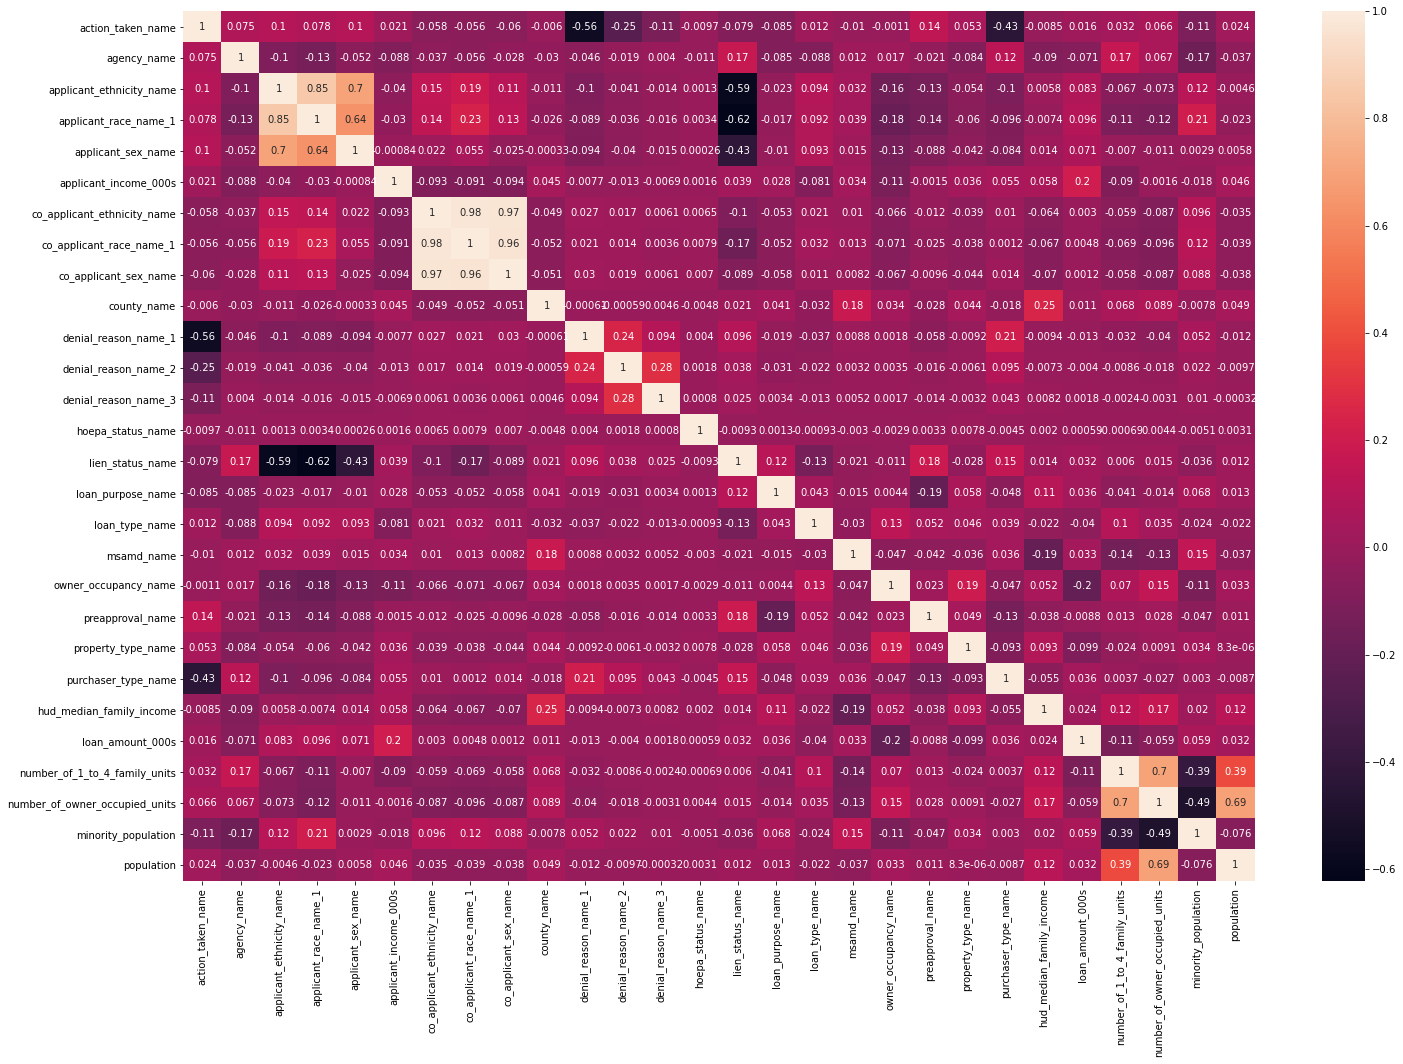

In [168]:
fig, ax = plt.subplots(figsize=(24, 16)) 
sns.heatmap(df.corr(), annot=True, ax = ax)

In [169]:
df.var()

action_taken_name                 3.874580e+00
agency_name                       2.723252e+00
applicant_ethnicity_name          5.795168e-01
applicant_race_name_1             2.909783e+00
applicant_sex_name                5.531276e-01
applicant_income_000s             6.420065e+04
co_applicant_ethnicity_name       2.143206e+00
co_applicant_race_name_1          8.174385e+00
co_applicant_sex_name             1.895167e+00
county_name                       2.541273e+02
denial_reason_name_1              1.813947e+00
denial_reason_name_2              4.989839e-01
denial_reason_name_3              1.107206e-01
hoepa_status_name                 1.535094e-04
lien_status_name                  5.560446e-01
loan_purpose_name                 4.161234e-01
loan_type_name                    4.669448e-01
msamd_name                        1.121180e+01
owner_occupancy_name              1.346682e-01
preapproval_name                  2.045008e-01
property_type_name                7.737123e-02
purchaser_typ

In [170]:
# Correlation depending on loan_approved

df.corr()['action_taken_name'].abs().sort_values(ascending = False)

action_taken_name                 1.000000
denial_reason_name_1              0.561347
purchaser_type_name               0.433250
denial_reason_name_2              0.254006
preapproval_name                  0.138681
denial_reason_name_3              0.114112
minority_population               0.106719
applicant_ethnicity_name          0.104521
applicant_sex_name                0.101489
loan_purpose_name                 0.084984
lien_status_name                  0.079086
applicant_race_name_1             0.077853
agency_name                       0.075381
number_of_owner_occupied_units    0.065863
co_applicant_sex_name             0.060500
co_applicant_ethnicity_name       0.058401
co_applicant_race_name_1          0.055634
property_type_name                0.052810
number_of_1_to_4_family_units     0.032131
population                        0.024291
applicant_income_000s             0.021226
loan_amount_000s                  0.015656
loan_type_name                    0.012310
msamd_name 

In [171]:
X = df.drop(['action_taken_name'], axis = 1)
y = df['action_taken_name']
y = np.array(y)

In [172]:
# How many denied or approved loans does the dataset contain?
# 'Application denied by financial institution': 0, 
# 'File closed for incompleteness': 1, 
# 'Application withdrawn by applicant': 2, 
# 'Application approved but not accepted': 3, 
# 'Loan purchased by the institution': 4, 
# 'Loan originated': 5

print('0 - Application denied by financial institution\n','1 - File closed for incompleteness\n','2 - Application withdrawn by applicant\n','3 - Application approved but not accepted\n','4 - Loan purchased by the institution\n','5 - Loan originated\n')
print('Distribution: \n' + str(pd.Series(y).value_counts()))
print('In Percent: \n' + str(pd.Series(y).value_counts() / pd.Series(y).count() * 100))

0 - Application denied by financial institution
 1 - File closed for incompleteness
 2 - Application withdrawn by applicant
 3 - Application approved but not accepted
 4 - Loan purchased by the institution
 5 - Loan originated

Distribution: 
5    90982
0    32005
4    24682
2    15765
1     6682
3     5743
dtype: int64
In Percent: 
5    51.735766
0    18.199239
4    14.035108
2     8.964568
1     3.799635
3     3.265684
dtype: float64


In [173]:
# The dataset is obviously very imbalanced. 
# A prediction with a high accuracy and Kappa is therefor only possible with a lot of try and error in feature optimization. 
# A possible solution: Oversampling!

In [174]:
# Oversampling: Balances the imbalanced dataset out by creating more samples with "canceled data" for better prediction results. 

# ros = RandomOverSampler(random_state=42)
# X_resampled, y_resampled = ros.fit_resample(X, y)

In [175]:
# Scaling 

X_scaled = StandardScaler().fit_transform(X)
# X_scaled = StandardScaler().fit_transform(X_resampled)

# Training

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.25, random_state = 3)
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size = 0.25, random_state = 3)

In [176]:
# # After Oversampling

# print('Distribution after Oversampling: \n' + str(pd.Series(y_resampled).value_counts()))

In [177]:
# Logistic Regression
model_lr = LogisticRegression().fit(X_train, y_train)
model_lr_prediction = model_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, model_lr_prediction)

conf_lr = confusion_matrix(y_test, model_lr_prediction)
clf_report_lr = classification_report(y_test, model_lr_prediction)

print(f"Accuracy Score of Logistic Regression is : {accuracy_lr}")
print(f"Confusion Matrix : \n{conf_lr}")
print(f"Classification Report : \n{clf_report_lr}")

Accuracy Score of Logistic Regression is : 0.7835096099169794
Confusion Matrix : 
[[ 5804     0   260     0     0  1814]
 [   24     1   245     0     0  1381]
 [   44     2   405     0     0  3512]
 [   13     0   119     0     0  1361]
 [    0     0     0     0  6187     0]
 [   77     0   666     0     0 22050]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.97      0.74      0.84      7878
           1       0.33      0.00      0.00      1651
           2       0.24      0.10      0.14      3963
           3       0.00      0.00      0.00      1493
           4       1.00      1.00      1.00      6187
           5       0.73      0.97      0.83     22793

    accuracy                           0.78     43965
   macro avg       0.55      0.47      0.47     43965
weighted avg       0.73      0.78      0.74     43965



C:\Users\Diana Jaffé\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Diana Jaffé\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Diana Jaffé\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetric

In [178]:
kappa_lr = cohen_kappa_score(y_test, model_lr_prediction)
kappa_lr

0.6375321882264622

In [179]:
# Random Forest
model_rf = RandomForestClassifier(n_estimators=1500).fit(X_train, y_train)
model_rf_prediction = model_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, model_rf_prediction)

conf_rf = confusion_matrix(y_test, model_rf_prediction)
clf_report_rf = classification_report(y_test, model_rf_prediction)

print(f"Accuracy Score of Random Forest is : {accuracy_rf}")
print(f"Confusion Matrix : \n{conf_rf}")
print(f"Classification Report : \n{clf_report_rf}")

KeyboardInterrupt: 

In [ ]:
kappa_rf = cohen_kappa_score(y_test, model_rf_prediction)
kappa_rf

0.7356358033024379

In [ ]:
# Decision Tree
model_dt = tree.DecisionTreeClassifier().fit(X_train, y_train)
model_dt_prediction = model_dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, model_dt_prediction)

conf_dt = confusion_matrix(y_test, model_dt_prediction)
clf_report_dt = classification_report(y_test, model_dt_prediction)

print(f"Accuracy Score of Decision Tree is : {accuracy_dt}")
print(f"Confusion Matrix : \n{conf_dt}")
print(f"Classification Report : \n{clf_report_dt}")

Accuracy Score of Decision Tree is : 0.7843788381931492
Confusion Matrix : 
[[ 6527     0   178   539   189     0   423]
 [    2     0     0     1     0     0     0]
 [  201     0   347   477   168     0   485]
 [  506     0   482  1297   424     0  1242]
 [  242     0   180   384   212     0   501]
 [    0     0     0     0     0  6090     0]
 [  467     0   559  1311   519     0 20013]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.82      0.83      0.83      7856
           1       0.00      0.00      0.00         3
           2       0.20      0.21      0.20      1678
           3       0.32      0.33      0.33      3951
           4       0.14      0.14      0.14      1519
           5       1.00      1.00      1.00      6090
           6       0.88      0.88      0.88     22869

    accuracy                           0.78     43966
   macro avg       0.48      0.48      0.48     43966
weighted avg       0.79      0.78      0.

C:\Users\Diana Jaffé\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Diana Jaffé\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Diana Jaffé\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [ ]:
kappa_dt = cohen_kappa_score(y_test, model_dt_prediction)
kappa_dt

0.6779336441401722

In [ ]:
# K-Fold DecisionTree
model_kfdt = cross_val_score(tree.DecisionTreeClassifier(max_depth = 7), X, y, cv=300)
print('Maximum: ', model_kfdt.max())
print('Mean: ', model_kfdt.mean())

model_kfdt = pd.Series(model_kfdt)
model_kfdt.plot()

C:\Users\Diana Jaffé\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=300.
  warnings.warn(("The least populated class in y has only %d"


KeyboardInterrupt: 

In [ ]:
# KNN
model_knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2).fit(X_train, y_train)
model_knn_prediction = model_knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, model_knn_prediction)

conf_knn = confusion_matrix(y_test, model_knn_prediction)
clf_report_knn = classification_report(y_test, model_knn_prediction)

print(f"Accuracy Score of Ada Boost Classifier is : {accuracy_knn}")
print(f"Confusion Matrix : \n{conf_knn}")
print(f"Classification Report : \n{clf_report_knn}")

Accuracy Score of Ada Boost Classifier is : 0.8408315516535505
Confusion Matrix : 
[[ 9386  4102]
 [ 2896 27582]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.76      0.70      0.73     13488
           1       0.87      0.90      0.89     30478

    accuracy                           0.84     43966
   macro avg       0.82      0.80      0.81     43966
weighted avg       0.84      0.84      0.84     43966



In [ ]:
kappa_knn = cohen_kappa_score(y_test, model_knn_prediction)
kappa_knn

0.6162155633207708

In [ ]:
# Ada Boost
model_ada = AdaBoostClassifier(n_estimators = 1000).fit(X_train, y_train)
model_ada_prediction = model_ada.predict(X_test)
accuracy_ada = accuracy_score(y_test, model_ada_prediction)

conf_ada = confusion_matrix(y_test, model_ada_prediction)
clf_report_ada = classification_report(y_test, model_ada_prediction)

print(f"Accuracy Score of Ada Boost Classifier is : {accuracy_ada}")
print(f"Confusion Matrix : \n{conf_ada}")
print(f"Classification Report : \n{clf_report_ada}")

Accuracy Score of Ada Boost Classifier is : 0.8924168675794932
Confusion Matrix : 
[[10518  2970]
 [ 1760 28718]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.86      0.78      0.82     13488
           1       0.91      0.94      0.92     30478

    accuracy                           0.89     43966
   macro avg       0.88      0.86      0.87     43966
weighted avg       0.89      0.89      0.89     43966



In [ ]:
kappa_ada = cohen_kappa_score(y_test, model_ada_prediction)
kappa_ada

0.7405752666098637

In [ ]:
# Gradient Boosting Classifier
model_gb = GradientBoostingClassifier().fit(X_train, y_train)
model_gb_prediction = model_gb.predict(X_test)

accuracy_gb = accuracy_score(y_test, model_gb_prediction)
conf_gb = confusion_matrix(y_test, model_gb_prediction)
clf_report_gb = classification_report(y_test, model_gb_prediction)

print(f"Accuracy Score of Ada Boost Classifier is : {accuracy_gb}")
print(f"Confusion Matrix : \n{conf_gb}")
print(f"Classification Report : \n{clf_report_gb}")

Accuracy Score of Ada Boost Classifier is : 0.8953054633125597
Confusion Matrix : 
[[10750  2738]
 [ 1865 28613]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.85      0.80      0.82     13488
           1       0.91      0.94      0.93     30478

    accuracy                           0.90     43966
   macro avg       0.88      0.87      0.87     43966
weighted avg       0.89      0.90      0.89     43966



In [ ]:
kappa_gb = cohen_kappa_score(y_test, model_gb_prediction)
kappa_gb

0.7493312210594085

In [ ]:
# XgBoost Classifier
model_xgb = XGBClassifier(booster = 'gbtree', learning_rate = 0.1, max_depth = 5, n_estimators = 180).fit(X_train, y_train)
model_xgb_prediction = model_xgb.predict(X_test)

accuracy_xgb = accuracy_score(y_test, model_xgb_prediction)
conf_xgb = confusion_matrix(y_test, model_xgb_prediction)
clf_report_xgb = classification_report(y_test, model_xgb_prediction)

print(f"Accuracy Score of XgBoost Classifier is : {accuracy_xgb}")
print(f"Confusion Matrix : \n{conf_xgb}")
print(f"Classification Report : \n{clf_report_xgb}")

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:05:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score of XgBoost Classifier is : 0.8979438657144156
Confusion Matrix : 
[[10917  2571]
 [ 1916 28562]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.85      0.81      0.83     13488
           1       0.92      0.94      0.93     30478

    accuracy                           0.90     43966
   macro avg       0.88      0.87      0.88     43966
weighted avg       0.90      0.90      0.90     43966



In [ ]:
kappa_xgb = cohen_kappa_score(y_test, model_xgb_prediction)
kappa_xgb

0.7567641995304736

In [ ]:
# Cat Boost Classifier
model_cat = CatBoostClassifier(iterations=100).fit(X_train, y_train)
model_cat_prediction = model_cat.predict(X_test)

accuracy_cat = accuracy_score(y_test, model_cat_prediction)
conf_cat = confusion_matrix(y_test, model_cat_prediction)
clf_report_cat = classification_report(y_test, model_cat_prediction)

print(f"Accuracy Score of Cat Boost Classifier is : {accuracy_cat}")
print(f"Confusion Matrix : \n{conf_cat}")
print(f"Classification Report : \n{clf_report_cat}")

Learning rate set to 0.5
0:	learn: 0.2766464	total: 243ms	remaining: 24.1s
1:	learn: 0.2398610	total: 321ms	remaining: 15.7s
2:	learn: 0.2316277	total: 437ms	remaining: 14.1s
3:	learn: 0.2281718	total: 534ms	remaining: 12.8s
4:	learn: 0.2263181	total: 609ms	remaining: 11.6s
5:	learn: 0.2236330	total: 685ms	remaining: 10.7s
6:	learn: 0.2222105	total: 762ms	remaining: 10.1s
7:	learn: 0.2205193	total: 876ms	remaining: 10.1s
8:	learn: 0.2194089	total: 1.04s	remaining: 10.5s
9:	learn: 0.2176777	total: 1.16s	remaining: 10.5s
10:	learn: 0.2163871	total: 1.29s	remaining: 10.4s
11:	learn: 0.2156611	total: 1.37s	remaining: 10s
12:	learn: 0.2152188	total: 1.44s	remaining: 9.62s
13:	learn: 0.2148818	total: 1.52s	remaining: 9.34s
14:	learn: 0.2144775	total: 1.62s	remaining: 9.2s
15:	learn: 0.2136884	total: 1.71s	remaining: 9s
16:	learn: 0.2130589	total: 1.82s	remaining: 8.9s
17:	learn: 0.2127217	total: 1.94s	remaining: 8.83s
18:	learn: 0.2121260	total: 2.1s	remaining: 8.97s
19:	learn: 0.2117950	tot

In [ ]:
kappa_cat = cohen_kappa_score(y_test, model_cat_prediction)
kappa_cat

0.7573217951498016

In [ ]:
# Extra Trees Classifier
model_etc = ExtraTreesClassifier().fit(X_train, y_train)
model_etc_prediction = model_etc.predict(X_test)

accuracy_etc = accuracy_score(y_test, model_etc_prediction)
conf_etc = confusion_matrix(y_test, model_etc_prediction)
clf_report_etc = classification_report(y_test, model_etc_prediction)

print(f"Accuracy Score of Cat Boost Classifier is : {accuracy_etc}")
print(f"Confusion Matrix : \n{conf_etc}")
print(f"Classification Report : \n{clf_report_etc}")

Accuracy Score of Cat Boost Classifier is : 0.88834553973525
Confusion Matrix : 
[[10800  2688]
 [ 2221 28257]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.83      0.80      0.81     13488
           1       0.91      0.93      0.92     30478

    accuracy                           0.89     43966
   macro avg       0.87      0.86      0.87     43966
weighted avg       0.89      0.89      0.89     43966



In [ ]:
kappa_etc = cohen_kappa_score(y_test, model_etc_prediction)
kappa_etc

0.7349319101044922

In [ ]:
# LGBM Classifier
model_lgbm = LGBMClassifier(learning_rate = 1).fit(X_train, y_train)
model_lgbm_prediction = model_lgbm.predict(X_test)

accuracy_lgbm = accuracy_score(y_test, model_lgbm_prediction)
conf_lgbm = confusion_matrix(y_test, model_lgbm_prediction)
clf_report_lgbm = classification_report(y_test, model_lgbm_prediction)

print(f"Accuracy Score of Cat Boost Classifier is : {accuracy_lgbm}")
print(f"Confusion Matrix : \n{conf_lgbm}")
print(f"Classification Report : \n{clf_report_lgbm}")

Accuracy Score of Cat Boost Classifier is : 0.882909520993495
Confusion Matrix : 
[[10866  2622]
 [ 2526 27952]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.81      0.81      0.81     13488
           1       0.91      0.92      0.92     30478

    accuracy                           0.88     43966
   macro avg       0.86      0.86      0.86     43966
weighted avg       0.88      0.88      0.88     43966



In [ ]:
kappa_lgbm = cohen_kappa_score(y_test, model_lgbm_prediction)
kappa_lgbm

0.7241621299662304

In [ ]:
# Voting Classifier
classifiers = [('Gradient Boosting Classifier', model_gb), ('Cat Boost Classifier', model_cat), ('XGboost', model_xgb),  
               ('Decision Tree', model_dt), ('Extra Tree', model_etc), ('Light Gradient', model_lgbm), ('Random Forest', model_rf), 
               ('Ada Boost', model_ada), ('Logistic', model_lr), ('Knn', model_knn)]
model_vc = VotingClassifier(estimators = classifiers).fit(X_train, y_train)
model_vc_prediction = model_vc.predict(X_test)

accuracy_vc = accuracy_score(y_test, model_vc_prediction)
conf_vc = confusion_matrix(y_test, model_vc_prediction)
clf_report_vc = classification_report(y_test, model_vc_prediction)

print(f"Accuracy Score of Voting Classifier is : {accuracy_vc}")
print(f"Confusion Matrix : \n{conf_vc}")
print(f"Classification Report : \n{clf_report_vc}")

Learning rate set to 0.5
0:	learn: 0.2766464	total: 58.1ms	remaining: 5.75s
1:	learn: 0.2398610	total: 132ms	remaining: 6.47s
2:	learn: 0.2316277	total: 196ms	remaining: 6.35s
3:	learn: 0.2281718	total: 261ms	remaining: 6.27s
4:	learn: 0.2263181	total: 327ms	remaining: 6.21s
5:	learn: 0.2236330	total: 388ms	remaining: 6.08s
6:	learn: 0.2222105	total: 451ms	remaining: 6s
7:	learn: 0.2205193	total: 511ms	remaining: 5.88s
8:	learn: 0.2194089	total: 571ms	remaining: 5.77s
9:	learn: 0.2176777	total: 632ms	remaining: 5.68s
10:	learn: 0.2163871	total: 686ms	remaining: 5.55s
11:	learn: 0.2156611	total: 736ms	remaining: 5.39s
12:	learn: 0.2152188	total: 784ms	remaining: 5.24s
13:	learn: 0.2148818	total: 835ms	remaining: 5.13s
14:	learn: 0.2144775	total: 888ms	remaining: 5.03s
15:	learn: 0.2136884	total: 939ms	remaining: 4.93s
16:	learn: 0.2130589	total: 992ms	remaining: 4.84s
17:	learn: 0.2127217	total: 1.05s	remaining: 4.77s
18:	learn: 0.2121260	total: 1.11s	remaining: 4.72s
19:	learn: 0.21179

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:08:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Diana Jaffé\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Score of Voting Classifier is : 0.8994905153982623
Confusion Matrix : 
[[10960  2528]
 [ 1891 28587]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.85      0.81      0.83     13488
           1       0.92      0.94      0.93     30478

    accuracy                           0.90     43966
   macro avg       0.89      0.88      0.88     43966
weighted avg       0.90      0.90      0.90     43966



In [ ]:
kappa_vc = cohen_kappa_score(y_test, model_vc_prediction)
kappa_vc

0.7605407043738746

In [ ]:
# Models Comparison
models = pd.DataFrame({
    'Model' : ['Logistic Regression', 'KNN', 'Decision Tree Classifier', 'Random Forest Classifier','Ada Boost Classifier',
             'Gradient Boosting Classifier', 'XgBoost', 'Cat Boost', 'Extra Trees Classifier', 'LGBM', 'Voting Classifier', 'K-Fold Decision Tree'],
    'Score' : [accuracy_lr, accuracy_knn, accuracy_dt, accuracy_rf, accuracy_ada, accuracy_gb, accuracy_xgb, accuracy_cat, 
              accuracy_etc, accuracy_lgbm, accuracy_vc, model_kfdt.mean()],
    'Kappa' : [kappa_lr, kappa_knn, kappa_dt, kappa_rf, kappa_ada, kappa_gb, kappa_xgb, kappa_cat, kappa_etc, kappa_lgbm, 
              kappa_vc, model_kfdt.mean()]
})


models.sort_values(by = 'Kappa', ascending = False)

,Model,Score,Kappa
11,K-Fold Decision Tree,0.881424,0.881424
10,Voting Classifier,0.899491,0.760541
3,Random Forest Classifier,0.898194,0.757832
7,Cat Boost,0.897830,0.757322
6,XgBoost,0.897944,0.756764
5,Gradient Boosting Classifier,0.895305,0.749331
4,Ada Boost Classifier,0.892417,0.740575
8,Extra Trees Classifier,0.888346,0.734932
9,LGBM,0.882910,0.724162
2,Decision Tree Classifier,0.862530,0.677262
